In [1]:
import random as rnd
import operator
import os
import time
import copy
import sys

# Data processing
import numpy as np                              # import numpy
import pandas as pd
import json
from scipy.stats import sem

# Plotting
import matplotlib.pyplot as plt                 # import matplotlib
import seaborn as sns
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.ticker as tckr

# Custom packages for simulation
# This works only if notebooks folder is in the "modules" parent folder
sys.path.insert(0, '..') # add modules folder (parent folder) into this notebook's path

# Institution modules
import institutions.dm_bargain as dm_bargain
import institutions.dm_travel as dm_travel

# Environment modules
import environment.dm_agents as dm_agents
import environment.dm_env as env
import environment.env_make_agents as make_env

# Simulation modules
import simulations.dm_sim_period as simulate
import simulations.dm_sim as sim_utils

# Utility modules
import dm_utils as dm
import dm_process_results as results


def print_agents(agents):
    for agent in agents:
        print(agent, type(agent))

def change_agents(agents, ratio=1):
    ZIDPR = dm_agents.ZIDPR
    """
    make a copy of agents at current location and change strategy to ZIDPR
    """

    # Pick a random set of agents to mutate (randomly at passed proportion - policy compliance rate)
    rn = np.random.default_rng()
    agent_indecies = list(range(len(agents)))
    complying_num = len(agents)*ratio
    non_int_part = complying_num%1
    add_num = 0
    if non_int_part != 0:
        # Randomly draw against remainder (keeps percetanges work across trials)
        if rn.random() < non_int_part:
            add_num += 1
            
    complying_num = int(complying_num) + add_num
    complying_inds = rn.choice(agent_indecies, size=complying_num)
    
    new_agents = []
    for k, agent in enumerate(agents):
        # change name
        if k in complying_inds: # These ones get Transformed
            name = agent.name
            s1 = name.split('_')
            name = s1[0] + '_' + s1[1] + '_ZIDPR'

            trader_type = agent.type
            payoff = agent.payoff
            money = agent.money
            location = agent.location
            lower_bound = agent.lower_bound
            upper_bound = agent.upper_bound
            move_error_rate = agent.movement_error_rate 
            # Added New
            #cont_flag = agent.contract_this_period
            reset_flag_frequency = agent.reset_flag_frequency
            reset_flag_min_agents = agent.reset_flag_min_agents
            reset_flag_on_random = agent.reset_flag_on_random
            reset_flag_window = agent.reset_flag_window
            reset_flag_min_trades = agent.reset_flag_min_trades
            # make a ZIDPR agent
            new_agent = dm_agents.ZIDPR(name, trader_type, payoff, money, location, 
                                   lower_bound, upper_bound, move_error_rate, reset_flag_frequency, reset_flag_min_agents,
                                    reset_flag_on_random, reset_flag_window, reset_flag_min_trades)

            #new_agent.set_contract_this_period(cont_flag)
            if new_agent.get_type() == "BUYER":
                vals = agent.get_values()
                new_agent.set_values(vals)
            else:
                cos = agent.get_costs()
                new_agent.set_costs(cos)
        else: # These ones do not
            new_agent = copy.deepcopy(agent)
            
        new_agents.append(new_agent)
        
    return new_agents

def change_back_agents(agents):
    
    ZIDPA = dm_agents.ZIDPA
    """Returns agents to type ZIDPA"""
    new_agents = []
    
    for k, agent in enumerate(agents):
        # change name
        name = agent.name
        s1 = name.split('_')
        name = s1[0] + '_' + s1[1] + '_ZIDPA'

        trader_type = agent.type
        payoff = agent.payoff
        money = agent.money
        location = agent.location
        lower_bound = agent.lower_bound
        upper_bound = agent.upper_bound
        cont_flag = agent.contract_this_period
        move_error_rate = agent.movement_error_rate 
        # Added New
        # print('+=+=+= ', cont_flag)
        reset_flag_frequency = agent.reset_flag_frequency
        reset_flag_min_agents = agent.reset_flag_min_agents
        reset_flag_on_random = agent.reset_flag_on_random
        reset_flag_window = agent.reset_flag_window
        reset_flag_min_trades = agent.reset_flag_min_trades
        # make a ZIDPA agent
        new_agent = dm_agents.ZIDPA(name, trader_type, payoff, money, location, 
                                   lower_bound, upper_bound, move_error_rate, reset_flag_frequency, reset_flag_min_agents,
                                    reset_flag_on_random, reset_flag_window, reset_flag_min_trades)
        
        new_agent.set_contract_this_period(cont_flag)

        if new_agent.get_type() == "BUYER":
            vals = agent.get_values()
            new_agent.set_values(vals)
        else:
            cos = agent.get_costs()
            new_agent.set_costs(cos)
        
        new_agents.append(new_agent)
        
    return new_agents


def make_event_sim(sim_name, num_periods, num_weeks,
             event_begin, event_end, market, agents,
             num_rounds, grid_size,
             num_traders, num_units,
             lower_bound, upper_bound,
             trader_objects, movement_error_rate=0, compliance_rate=1, return_df=False, return_period_df=False, reset_flag_frequency=None, reset_flag_min_agents=None,
             reset_flag_on_random=False, reset_flag_window=None, reset_flag_min_trades=1):
    """Runs one complete simulation and returns data in
        effs[treatment][trial].  Causes epidemic event from event_begin to event_end
        return_df = True -> return as dataframe
    """ 

    if return_df:
        # Store parameters
        df_cols_param = ['sim_name', 'num_traders', 'num_units', 'num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'lower_bound', 'upper_bound', 'trader_objects', 'movement_error_rate', 'compliance_rate', 
                         'event_bgin', 'event_end']
        # Store results
        df_cols_results = ['week', 'contracts', 'grids', 'eff', 'type_effs']
        df_cols = df_cols_param + df_cols_results
        df_data = []

    if return_period_df:
        if return_df:
            df_period_cols = df_cols + ['period'] + ['period_locs']
            df_period_data = []
        else:
            raise ValueError("Need to pass return_df=True with return_period_df=True")
    
    data = {}
    for week in range(num_weeks):
        
        if week == event_begin:
            agents = change_agents(agents, compliance_rate)
        if week == event_end:
            agents = change_back_agents(agents)
            
        data[week] = {}
        for agent in agents:
            agent.start(None)
        contracts = []
        sim_grids = []
        sim1 = simulate.SimPeriod(sim_name, num_rounds, agents, 
               market, grid_size)
        
        for period in range(num_periods):
            sim1.run_period()
            grid = sim1.get_grid()
            sim_grids.append(grid)
            contracts.extend(sim1.get_contracts())

            if return_period_df:
                period_data = [sim_name, num_traders, num_units, num_weeks, num_periods, num_rounds, grid_size, lower_bound, upper_bound, trader_objects, movement_error_rate, compliance_rate, event_begin, event_end, week, 
                         sim1.get_contracts(), grid, None, None, period, copy.deepcopy(grid)]
                df_period_data.append(period_data)

                if week == 0 and period == 0:
                    period_data = [sim_name, num_traders, num_units, num_weeks, num_periods, num_rounds, grid_size, lower_bound, upper_bound, trader_objects, movement_error_rate, compliance_rate, event_begin, event_end, -1, 
                             None, copy.deepcopy(sim1.get_initial_grid()), None, None, -1, copy.deepcopy(sim1.get_initial_grid())]
                    df_period_data.append(period_data)
        
        data[week]['contracts'] = contracts
        data[week]['grids'] = sim_grids
        
        # process results
        pr1 = results.ProcessResults(market, sim_name, agents, contracts)
        pr1.calc_efficiency()
        pr1.get_results()
        eff = pr1.get_efficiency()
        type_eff = pr1.get_type_surplus()
        data[week]['eff'] = eff # single item put in list to faciliatate looping through data 
        data[week]['type_effs'] = type_eff

        if return_df:
            week_data = [sim_name, num_traders, num_units, num_weeks, num_periods, num_rounds, grid_size, lower_bound, upper_bound, trader_objects, movement_error_rate, compliance_rate, event_begin, event_end, week, 
                         contracts, sim_grids, eff, type_eff]
            df_data.append(week_data)

    if return_df:
        df_out = pd.DataFrame(data=df_data, columns=df_cols)
        if return_period_df:
            period_df_out = pd.DataFrame(data=df_period_data, columns=df_period_cols)
            return df_out, period_df_out
        else:
            return df_out
    else:
        return data


def make_event_monte_carlo(sim_name, num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects, movement_error_rate=0, compliance_rate=1, return_df=False, return_period_df=False, reset_flag_frequency=None, reset_flag_min_agents=None,
                    reset_flag_on_random=False, reset_flag_window=None, reset_flag_min_trades=1):
    """Runs one complete simulation and returns data in
        effs[treatment][trial]
        compliance_rate = ratio of agents complying with social distancing, e[0, 1]
        movement_error_rate = ratio of FULLY random moves, not employing strategy of movement, e[0, 1]
        return_df = True -> return as dataframe
    """ 

    sim_data = {}
    sim_data['parms'] = {'sim_name': sim_name, 'num_traders': num_traders, 'num_units': num_units,
                         'num_weeks': num_weeks, 'num_periods': num_periods, 'num_rounds': num_rounds,
                         'grid_size': grid_size, 'lower_bound':lower_bound, 'upper_bound': upper_bound,
                         'trader_objects': trader_objects, 'movement_error_rate': movement_error_rate, 'compliance_rate': compliance_rate}

    if return_df:
        # Store parameters
        df_cols_param = ['sim_name', 'num_traders', 'num_units', 'num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'lower_bound', 'upper_bound', 'trader_objects', 'movement_error_rate', 'compliance_rate',
                        'event_begin', 'event_end']
        # Store outputs
        df_cols_results = ['week', 'contracts', 'grids', 'eff', 'type_effs']
        df_cols_trial = ['trial']
        df_cols = df_cols_param + df_cols_results + df_cols_trial
        df_out = pd.DataFrame(columns=df_cols)

    if return_period_df:
        if return_df:
            period_out_df = pd.DataFrame(columns=df_out.columns)
        else:
            raise ValueError("Need to be in return_df=True mode to get period details")
        
    # Run n trials of this setup
    for trial in range(num_trials):

        agent_maker = make_env.MakeAgents(num_traders, trader_objects, num_units, 
                                            grid_size, lower_bound, upper_bound, False, movement_error_rate, reset_flag_frequency=reset_flag_frequency, 
                                            reset_flag_min_agents=reset_flag_min_agents, reset_flag_on_random=reset_flag_on_random, reset_flag_window=reset_flag_window, 
                                          reset_flag_min_trades=reset_flag_min_trades)
        agent_maker.make_agents()
        agent_maker.set_locations(grid_size)
        agents = agent_maker.get_agents()

        # set up market
        agent_maker.make_market(sim_name)
        market = agent_maker.get_market()

        if not return_period_df:
            trial_data = make_event_sim(sim_name, num_periods, num_weeks, 
                                        event_begin, event_end, market, agents,
                                        num_rounds, grid_size,
                                        num_traders, num_units,
                                        lower_bound, upper_bound,
                                        trader_objects, movement_error_rate, compliance_rate, return_df, reset_flag_frequency=reset_flag_frequency, 
                                            reset_flag_min_agents=reset_flag_min_agents, reset_flag_on_random=reset_flag_on_random, reset_flag_window=reset_flag_window, 
                                        reset_flag_min_trades=reset_flag_min_trades)
        else:
            trial_data, trial_period_data = make_event_sim(sim_name, num_periods, num_weeks, 
                            event_begin, event_end, market, agents,
                            num_rounds, grid_size,
                            num_traders, num_units,
                            lower_bound, upper_bound,
                            trader_objects, movement_error_rate, compliance_rate, return_df, return_period_df, reset_flag_frequency=reset_flag_frequency, 
                                            reset_flag_min_agents=reset_flag_min_agents, reset_flag_on_random=reset_flag_on_random, reset_flag_window=reset_flag_window, 
                                                           reset_flag_min_trades=reset_flag_min_trades)
            
        sim_data[trial] = trial_data

        if return_df:
            trial_data['trial'] = trial
            if len(df_out) == 0:
                df_out = trial_data
            else:
                df_out = pd.concat([df_out, trial_data])
                
        if return_period_df:
            trial_period_data['trial'] = trial
            if len(period_out_df) == 0:
                period_out_df = trial_period_data
            else:
                period_out_df = pd.concat([period_out_df, trial_period_data])
    
    if return_df:
        df_out = df_out.reset_index(drop=True)
        df_out['num_trials'] = num_trials
        if return_period_df:
            period_out_df = period_out_df.reset_index(drop=True)
            period_out_df['num_trials'] = num_trials
            return df_out, period_out_df
        else:
            return df_out
    else:
        return sim_data


def format_df_for_boxplot(data_df, x_var, y_var, x_range=None):
    """Reformats dataframe to be a matrix of [[y_1, ..., y_n]], [[y_2, ..., y_n]], ...]; length = length of x; indexes correspond to x's; for use in the box-plotting functions
        x_range (iterable): If using non-numeric x, need to specify a custom range for these, as the function cannot otherwise parse the data range.
    """

    matrix_out = []
    
    # If not provided, figure out x-range
    if x_range is None:
        x_min = data_df[x_var].min()
        x_max = data_df[x_var].max()
        x_range = range(x_min, x_max+1)

    # Traverse the dataframe
    for x in x_range:
        x_match = data_df[data_df[x_var]==x]
        y_vals = list(x_match[y_var].values)
        this_row = y_vals
        matrix_out.append(this_row)
    
    return matrix_out

In [2]:
def plot_boxplot_data(boxplot_data, title=None, y_lab=None, x_lab=None, x_ticks=None, x_tick_labs=None):
    fig, ax1 = plt.subplots(figsize=(8, 8))
    fig.canvas.manager.set_window_title('A Boxplot Example')
    fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)
    
    bp = ax1.boxplot(boxplot_data, notch=True, sym='+', vert=1, whis=1.5)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')
    
    # Add a horizontal grid to the plot, but make it very light in color
    # so we can use it for reading data values but not be distracting
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)
    
    ax1.set(
        axisbelow=True,  # Hide the grid behind plot objects
        title="Distribution of Weekly Efficiencies Across Trials",
        xlabel="Weeks",
        ylabel='Efficiency',
    )

    if title is not None:
        ax1.set(title=title)

    if y_lab is not None:
        ax1.set(ylabel=y_lab)

    if x_lab is not None:
        ax1.set(xlabel=x_lab)

    if x_ticks is not None:
        ax1.set_xticks(x_ticks)

    if x_tick_labs is not None:
        ax1.set_xticklabels(x_tick_labs, fontsize=12)

    # Override standard tick labels with provided x_ticks if x_tick_labs not provided
    if x_ticks is not None and x_tick_labs is None:
        ax1.set_xticklabels(x_ticks, fontsize=12)
    
    plt.show()

In [3]:
def avg_df_obs(df_data, x_var, y_var, form="mean", percentiles=None):
    """Return the central tendency of the y_var observations, grouped on the x_var.
        form = mean or median
        percentiles (list) = None or list of percentiles to return
    """

    grouped = df_data[[x_var, y_var]].groupby(x_var)

    # TODO implement mean
    if form == "mean":
        df_out = grouped.mean()
    # Todo implement median
    elif form == "median":
        df_out = grouped.median()
        
    # Todo implement percentile
    if percentiles is not None:
        for perc in percentiles:
            colname = y_var + "_q_" + str(perc)
            perc_frame = grouped.quantile(q=perc)
            perc_frame = perc_frame.rename(columns={y_var: colname})
            print(df_out.head())
            print(perc_frame.head())
            df_out = df_out.join(perc_frame)
    
    return df_out.reset_index()

In [4]:
def compare_graph(dfs, x_var, y_var, form="line", form_type="mean", line_labs=None, title=None, x_ticks=None, x_tick_labs=None):
    """If not line_labs list provided, uses the names of the simulations in the dataframes."""

    if line_labs is None:
        line_labs = []
        for i in range(len(dfs)):
            line_labs.append(dfs[i]["sim_name"].values[0])

    if x_tick_labs is None and x_ticks is not None:
        x_tick_labs = x_ticks

    plt.figure()
    plt.title(title)
    plt.xlabel("Week")
    plt.ylabel("Efficiency")
    plt.xticks(ticks=week_xticks, labels=week_xticks)
    for i in range(len(treat_names)):
        this_lab = treat_names[i]
        this_df = treat_dfs[i]
        mean_df = avg_df_obs(this_df, "week", "eff", form_type)
        plt.plot(mean_df["week"], mean_df["eff"], label=this_lab)
    
    plt.legend()
    plt.show()
    

In [5]:
def three_d_grid(grid_size):
    """Transforms a grid size into a projected-vector 3d grid - represented as a nm and mn vectors"""    
    # create dimmensions - currently only for square grid of nXn
    colnames = ['D1', 'D2']
    grid_base = []
    n = np.arange(grid_size)
    m = np.arange(grid_size)
    for n1 in n:
        for m1 in m:
            grid_base.append([n1, m1])

    grid_df = pd.DataFrame(data=grid_base, columns=colnames)
    return grid_df

def plottable_locs(locs, grid_df, investigated="Agents"):
    """Plots a location-agents dictionary onto a 3d grid based projects vectors"""
    grid_new = grid_df.copy()
    grid_new[investigated] = 0
    for loc in locs.keys():
        agent_at_key = len(locs[loc])
        d1 = loc[0]
        d2 = loc[1]
        spot_ind = grid_new[(grid_new['D1'] == d1) & (grid_new['D2'] == d2)].index
        grid_new[investigated].iloc[spot_ind] = agent_at_key
    return grid_new

def collate_loc_plots(sim_df, investigated="Agents"):
    """Create large stacked DF with agent locations for every trial, week, and period
        sim_df: dataframe of results
        investigated: the value to report in the collated plotted grid df
        
        returns:
            dataframe of stacked form with the grid and observed vars at the points per trial, week, period
    """
    num_trials = sim_df['num_trials'].loc[0]
    num_weeks = sim_df['num_weeks'].loc[0]
    num_periods = sim_df['num_periods'].loc[0]
    num_rounds = sim_df['num_rounds'].loc[0]
    grid_size = sim_df['grid_size'].loc[0]
    num_traders = sim_df['grid_size'].loc[0]

    grd = three_d_grid(grid_size)
    
    control_cols = ['num_trials', 'num_weeks', 'num_periods', 'num_rounds', 'grid_size', 'num_traders', 'num_units', 'lower_bound', 'upper_bound']
    rel_df = sim_df[list(set(sim_df.columns) - set(control_cols))]

    out_df = pd.DataFrame()

    # Traverse the simulation df and save stacked plots
    for trial in range(num_trials):
        trial_df = rel_df[rel_df['trial']==trial]
        init_ind = trial_df[(trial_df['week']==-1) & (trial_df['period']==-1)].index
        init_loc = trial_df['period_locs'].loc[init_ind].values[0]
        init_plot = plottable_locs(init_loc, grd)
        init_plot['trial'] = trial
        init_plot['week'] = -1
        init_plot['period'] = -1
        out_df = pd.concat([out_df, init_plot])
        for week in range(num_weeks):
            week_df = trial_df[trial_df['week']==week]
            for period in range(num_periods):
                per_ind = week_df[week_df['period']==period].index
                per_loc = week_df['period_locs'].loc[per_ind].values[0]
                per_plot = plottable_locs(per_loc, grd)
                per_plot['trial'] = trial
                per_plot['week'] = week
                per_plot['period'] = period
                out_df = pd.concat([out_df, per_plot])

    return out_df

def graph_plotted(plotted, title_val=None, hue_val="Agents", hue_norm_val=(0, 1), size_val="Agent", size_norm_val=(0, 1), legend=False, palette="hot_r",
                 integer_bar=True, subtitle=False):
    """Visualize the data on a 2D grid to show the locations and values of the investigated value"""
    
    g = sns.relplot(
        data=plotted,
        x="D1", y="D2", hue=hue_val, size="Agents",
        palette=palette, hue_norm=hue_norm_val, edgecolor=".7",
        height=10, sizes=(35, 400), size_norm=size_norm_val, legend=False
    )

    if not subtitle:
        subtitle = ""
    
    # Tweak the figure to finalize
    g.set(xlabel=subtitle, ylabel="", aspect="equal", xticks=[], yticks=[], xticklabels=[], yticklabels=[], title=title_val)
    g.despine(left=True, bottom=True)
    g.ax.margins(.03)
    plt.grid()

    if legend:
        bar = g.figure.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_val, cmap=palette),
             ax=plt.gca(), label=hue_val, aspect=100, shrink=0.8)
        
        if integer_bar:
            bar.locator = tckr.MaxNLocator(integer=True)
        

    return g

import warnings
import moviepy.video.io.ImageSequenceClip
from PIL import Image, ImageFile
# import PIL and PIL.ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

default_movie_stem = "loc_movie"
default_graph_folder = "loc_plots"
if not os.path.isdir(default_graph_folder):
    os.mkdir(default_graph_folder)

def to_len_str(number, str_len):
    base_str = str(number)
    new_str = '0'*(str_len-len(base_str)) + base_str
    return new_str

def movie_plotted(collated_plotted, movie_name=None, graph_folder=None, title_val=None, hue_val="Agents", size_val="Agents", scale="relative", hue_max=None, 
                  size_max=None, week_max=None, period_max=None, include_init=True, fps=1, subtitle=True):
    """
    collated_plotted: one trial (or an average of trials) plotted using 
    movie_name: The name to save the movie under (if not provided - uses default for the notebook + timestamp)
    graph_folder: The name of the folder to save the graphs in (if not provided - uses default for the notebook + new folder timestamp)
    title_val: what title to use
    hue_val: what to place the hue on
    size_val: what to place size on
    scale: the way in which normalization will be applied to graph hues and sizes
    hue_max: used for normalization of hue in absolute scale case
    size_max: used for normalization of size in absolute scale case
    """
    timestamp = int(time.time()*1000000) # integer to not have issues with os
    if graph_folder is None:
        graph_folder = default_graph_folder + "/plots_" + str(timestamp)
    else:
        graph_folder = default_graph_folder + "/" + graph_folder
        
    if movie_name is None:
        movie_name = graph_folder + "/movie.mp4"
    else:
        movie_name = graph_folder + "/" + movie_name
        
    if scale == "absolute":
        if hue_max is None:
            raise ValueError("Hue max must be defined for absolute scaling")
        if size_max is None:
            raise ValueError("Size max must be defined for absolute scaling")
    elif scale == "relative":
        hue_max = np.max(collated_plotted[hue_val])
        size_max = np.max(collated_plotted[size_val])
        
    hue_norm = colors.Normalize(vmin=0, vmax=hue_max)
    size_norm = colors.Normalize(vmin=0, vmax=size_max)
    
    # Check if directories exists
    if not os.path.isdir(graph_folder):
        os.mkdir(graph_folder)

    if os.path.isfile(movie_name):
        warnings.warn("Movie name already used")
        return
        # raise ValueError("Movie name already used")

    if week_max is None:
        week_max = np.max(collated_plotted['week'])

    week_digits = len(str(week_max))

    if period_max is None:
        period_max = np.max(collated_plotted['period'])

    period_digits = len(str(week_max))

    img_names = []
    if include_init:
        init_plot = collated_plotted[(collated_plotted['week']==-1) & (collated_plotted['period']==-1)]
        init_name = graph_folder + "/init_plot.png"
        img_names.append(init_name)
        if subtitle:
                subtitle = "Initial Position"
        init_graph = graph_plotted(init_plot, title_val=title_val, hue_val=hue_val, hue_norm_val=hue_norm, size_val=size_val, size_norm_val=size_norm, 
                                   legend=True, subtitle=subtitle)
        plt.savefig(init_name)
        plt.close()
    
    for week in range(0, week_max+1):
        for period in range(0, period_max+1):
            this_plot = collated_plotted[(collated_plotted['week']==week) & (collated_plotted['period']==period)]
            weekstr = to_len_str(week, week_digits)
            prdstr = to_len_str(period, period_digits)
            this_image_name = graph_folder + "/w" + weekstr + "p" + prdstr + "_plot.png"
            img_names.append(this_image_name)
            if subtitle:
                subtitle = "Week: "+weekstr+"; Period: "+prdstr
            
            this_graph = graph_plotted(this_plot, title_val=title_val, hue_val=hue_val, hue_norm_val=hue_norm, size_val=size_val, size_norm_val=size_norm,
                                      legend=True, subtitle=subtitle)
            plt.savefig(this_image_name)
            plt.close()
            

    # Create movie out of plotted graphs
    fps = fps
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(img_names, fps=fps)
    clip.write_videofile(movie_name)



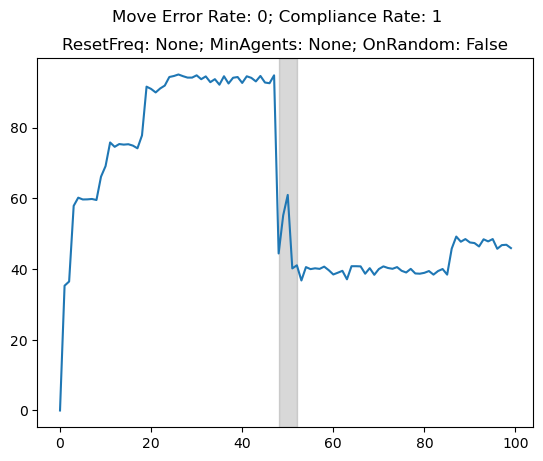

In [6]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

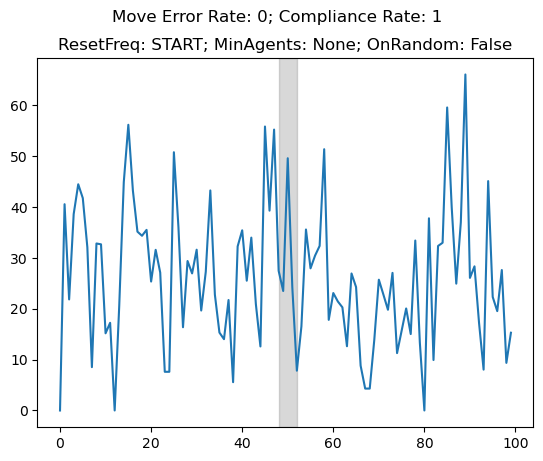

In [7]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq="START"
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

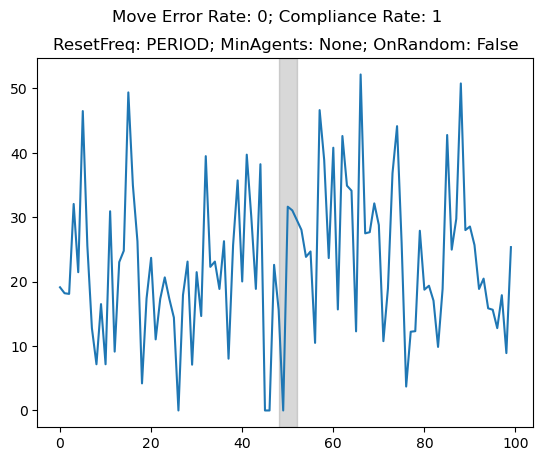

In [8]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq="PERIOD"
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

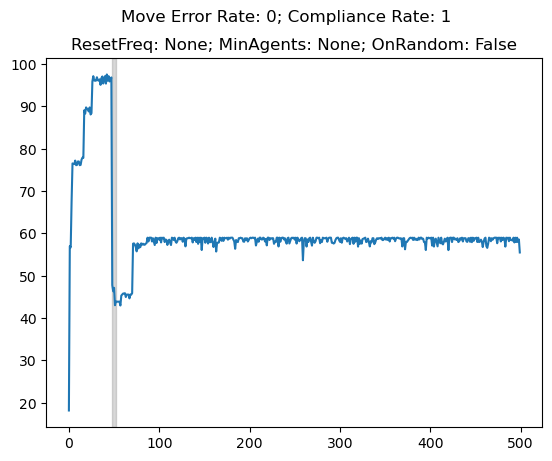

In [9]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

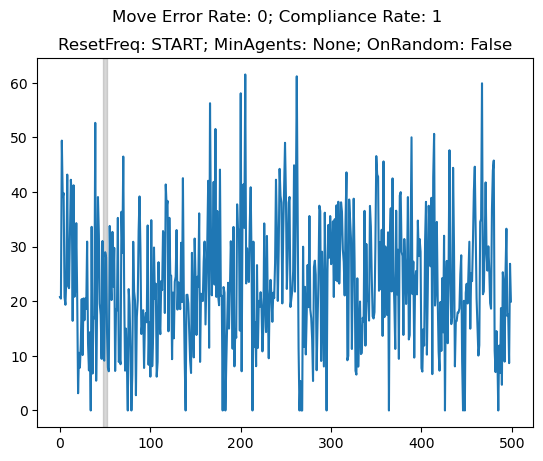

In [10]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq="START"
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

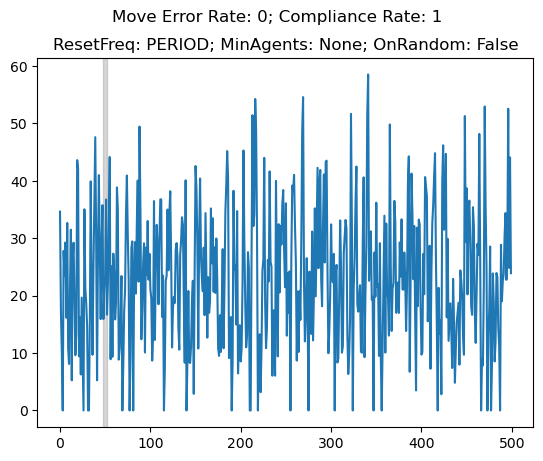

In [11]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq="PERIOD"
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

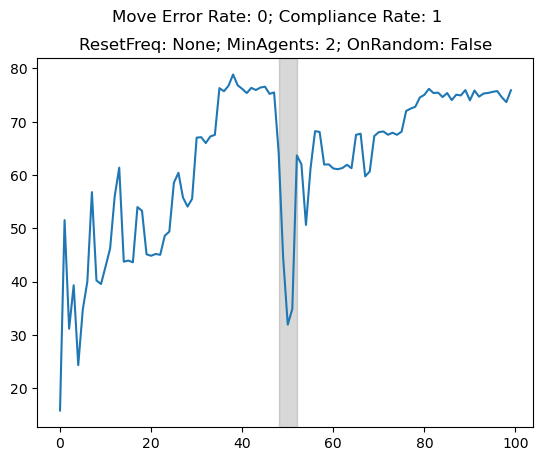

In [12]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq=None
min_agents=2
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

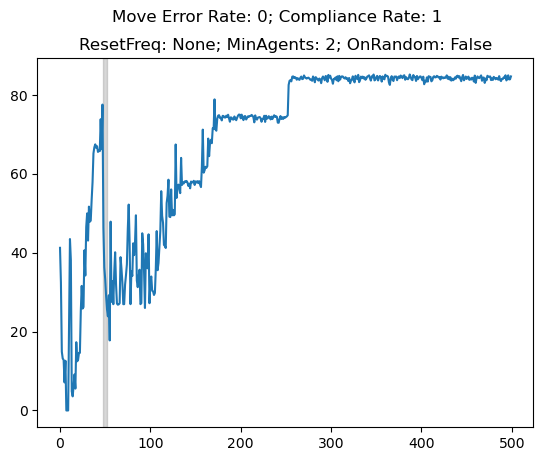

In [13]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq=None
min_agents=2
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

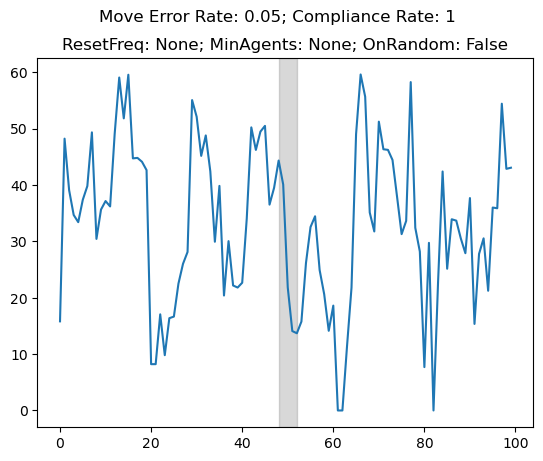

In [14]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.05
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

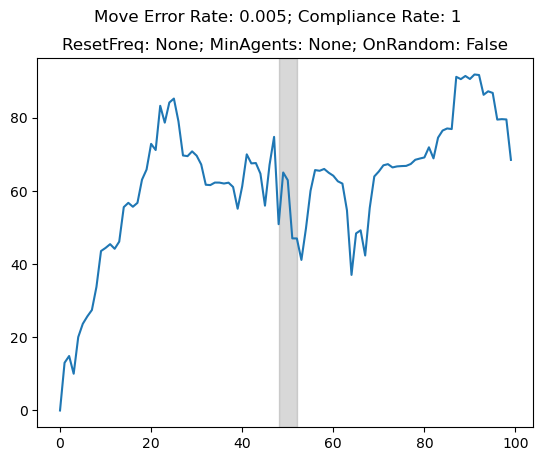

In [15]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.005
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

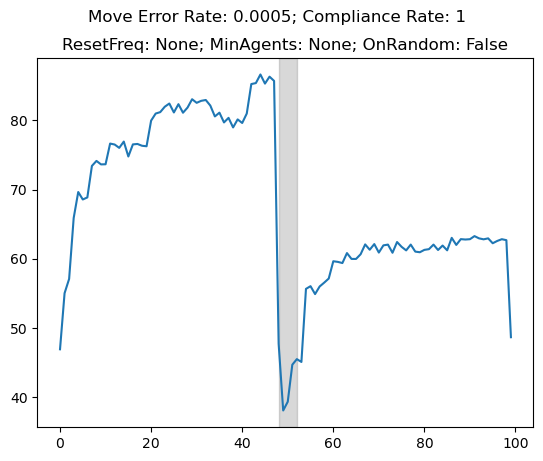

In [16]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.0005
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

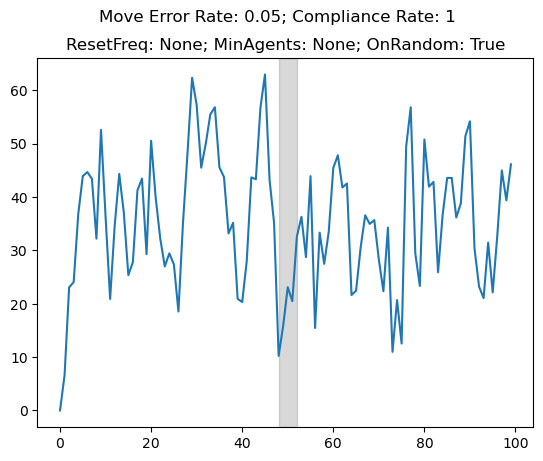

In [17]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.05
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=True

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

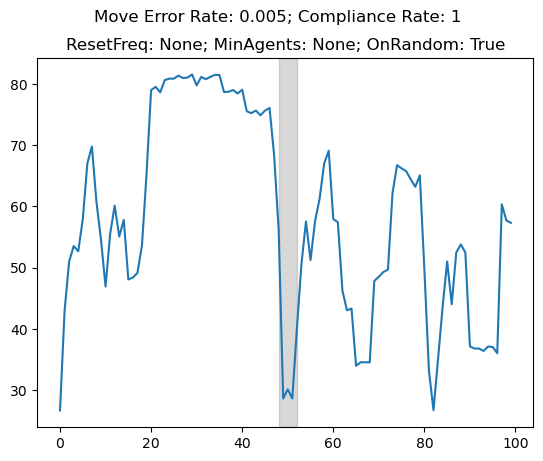

In [18]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.005
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=True

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

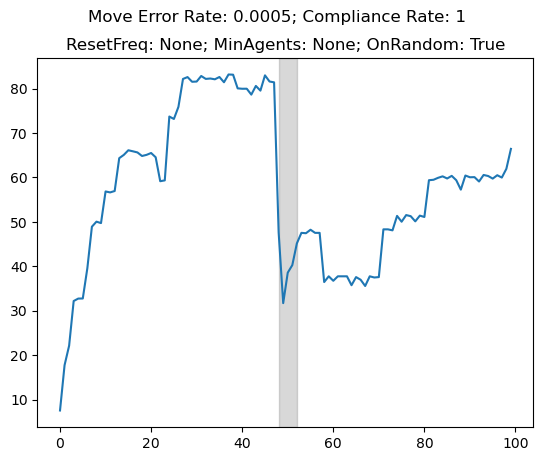

In [19]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.0005
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=True

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

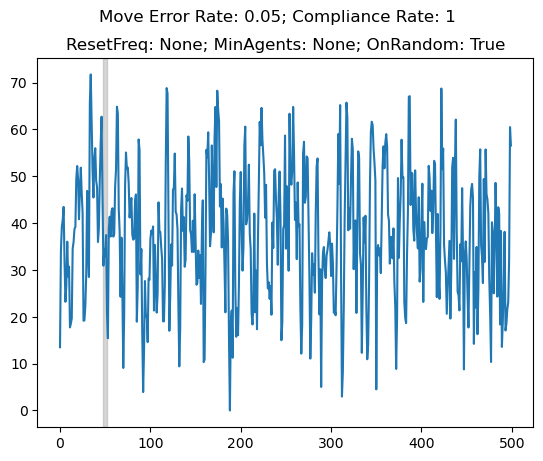

In [20]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.05
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=True

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

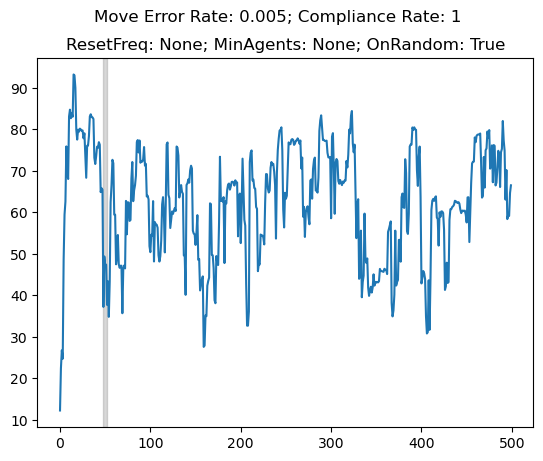

In [21]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.005
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=True

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

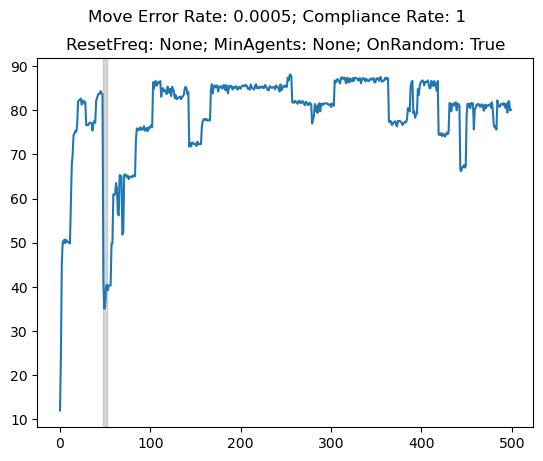

In [22]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.0005
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=True

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

plt.plot(test1['eff'])
plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
plt.suptitle(f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}")
plt.title(f"ResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}")
plt.show()

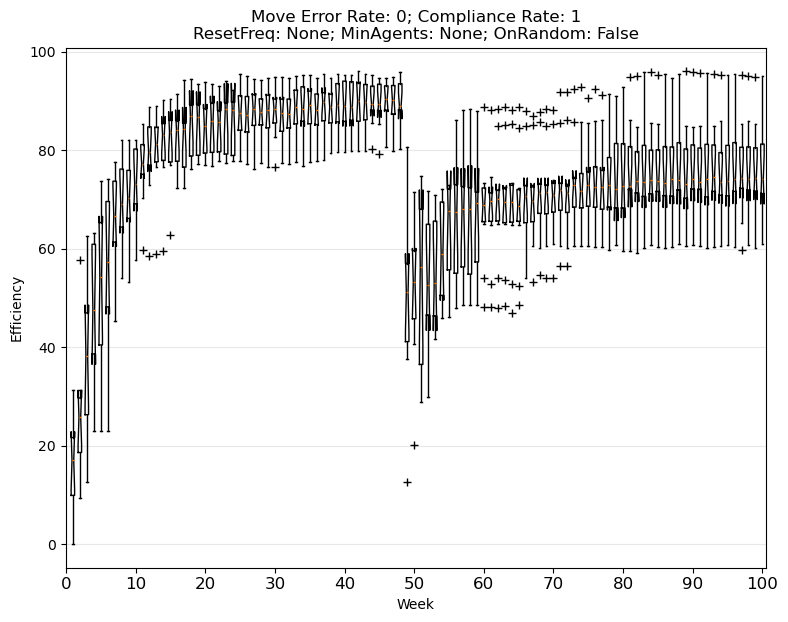

In [23]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 10))

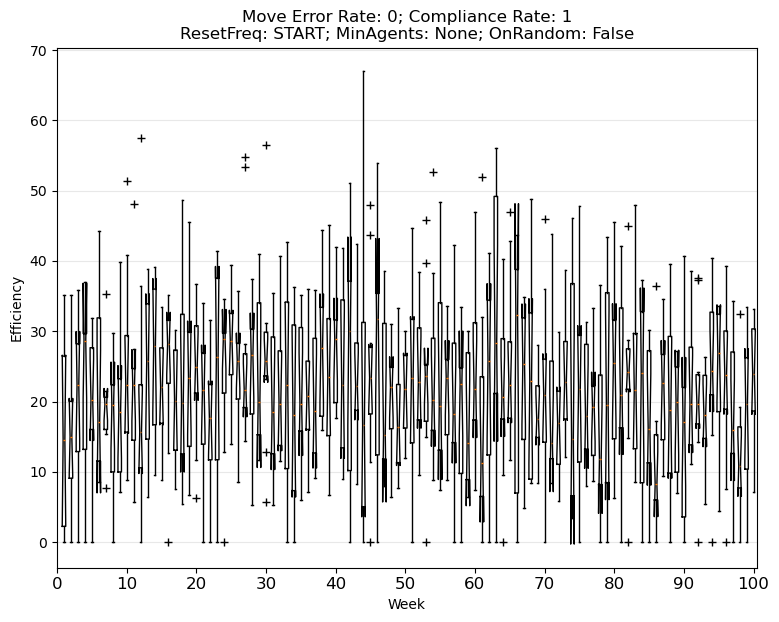

In [24]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq="START"
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 10))

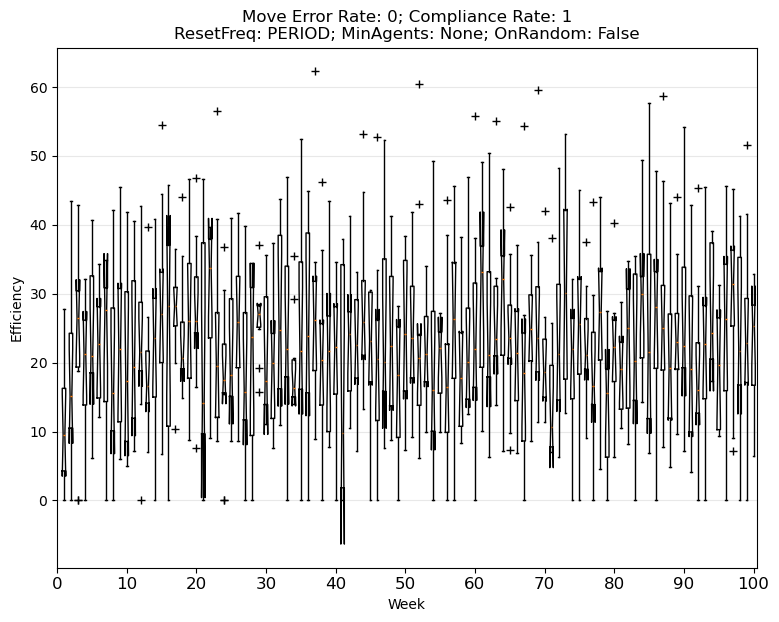

In [25]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq="PERIOD"
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 10))

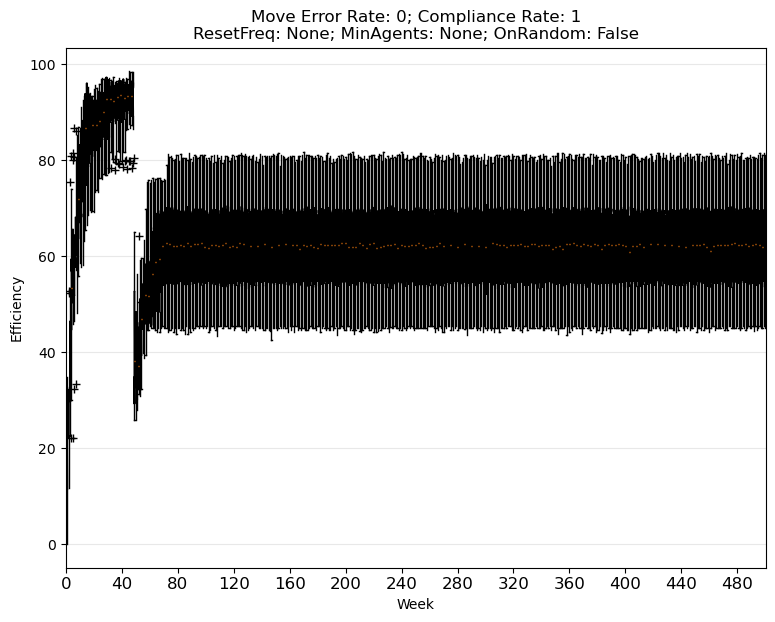

In [26]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 40))

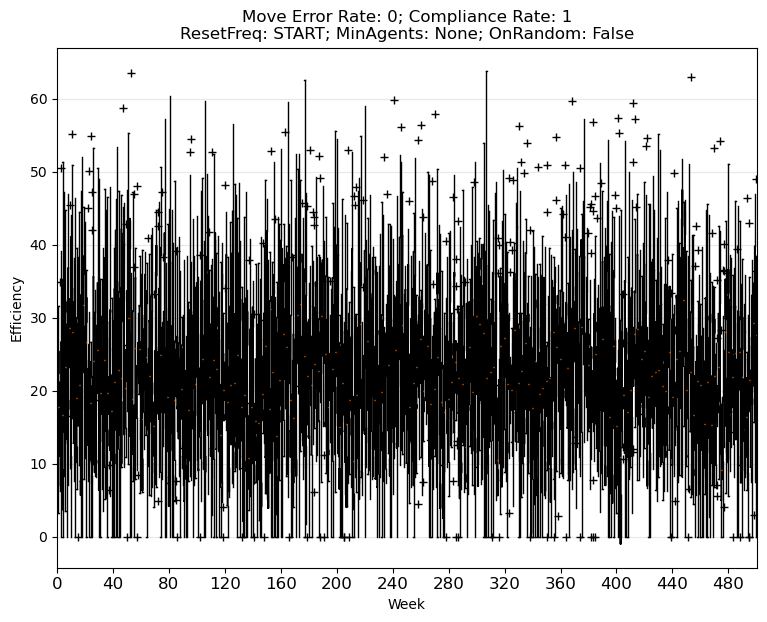

In [27]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq="START"
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 40))

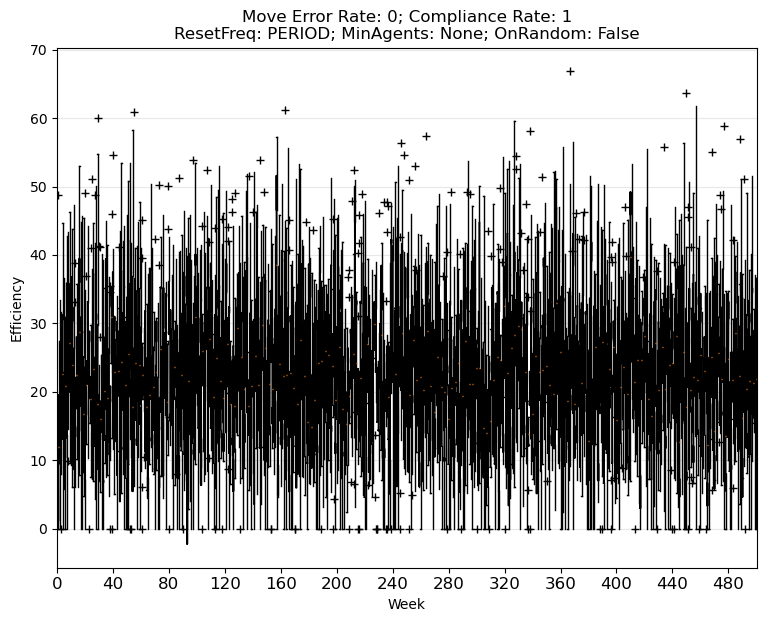

In [28]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq="PERIOD"
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 40))

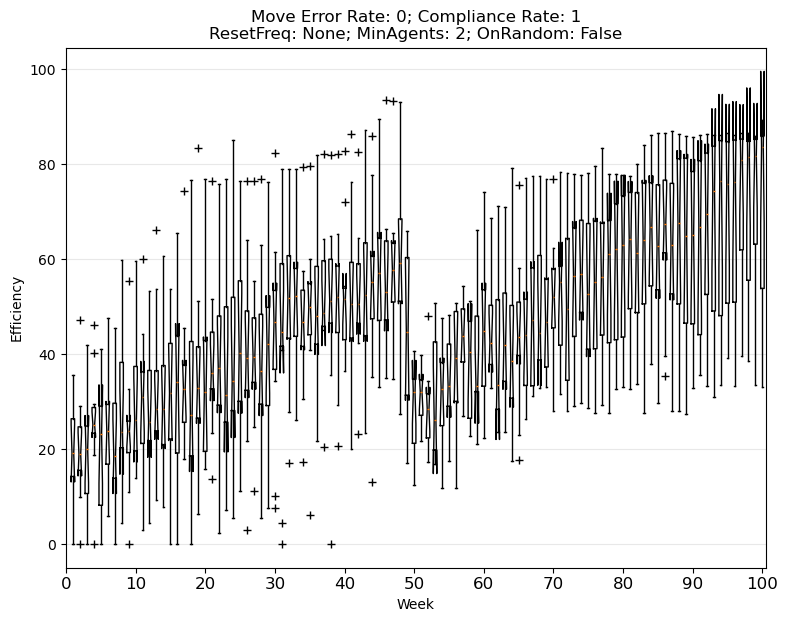

In [29]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq=None
min_agents=2
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 10))

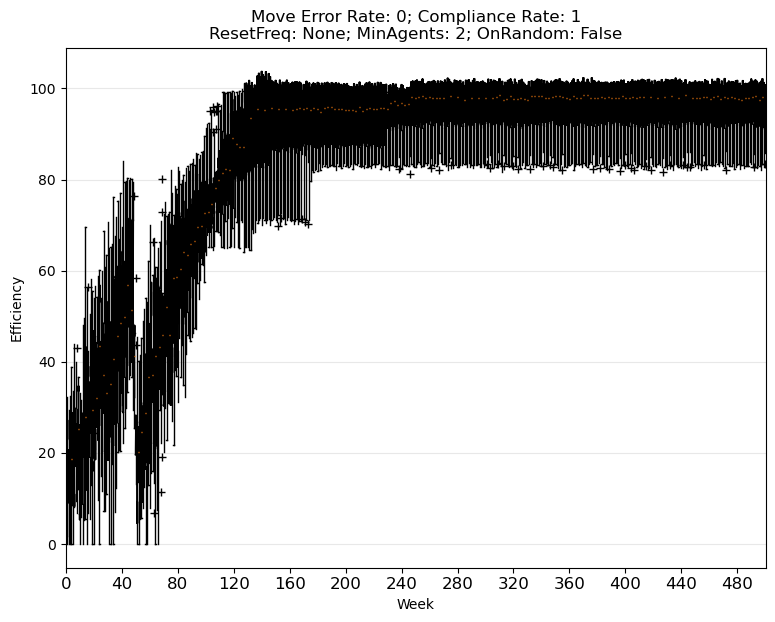

In [30]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq=None
min_agents=2
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 40))

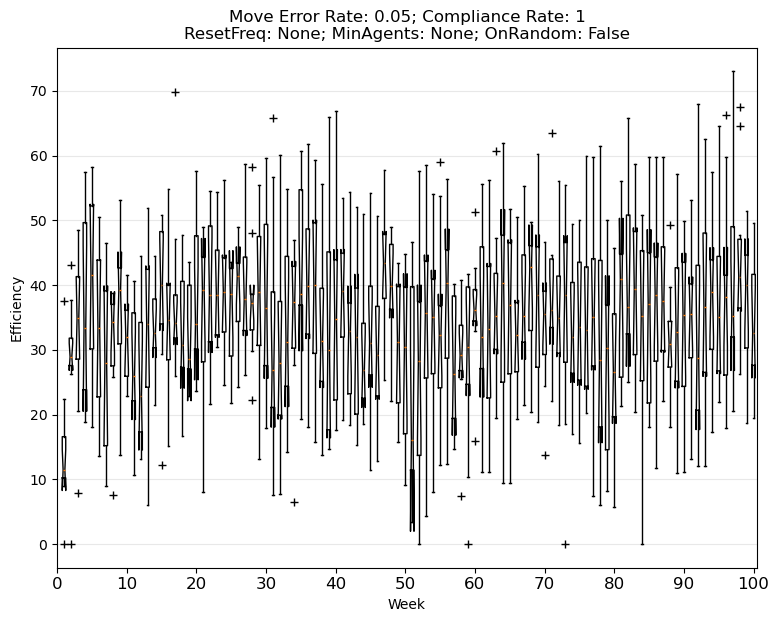

In [31]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.05
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 10))

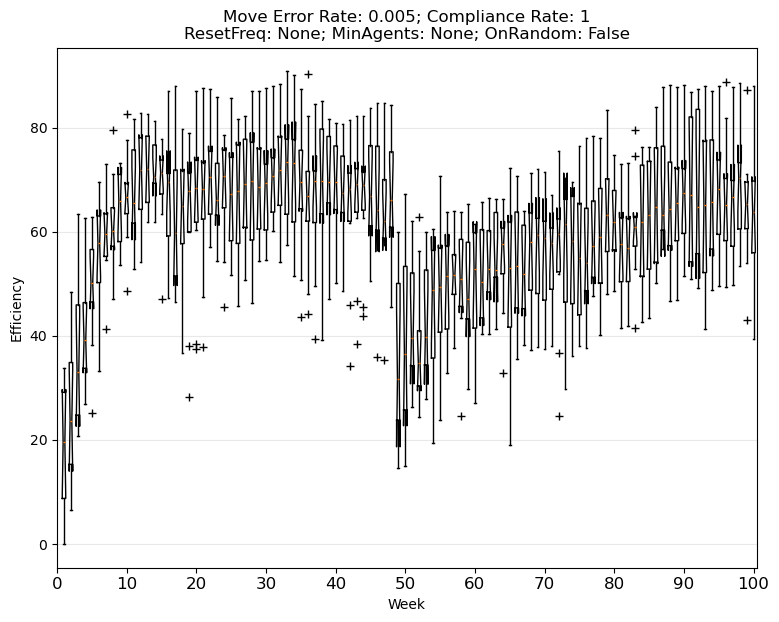

In [32]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.005
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 10))

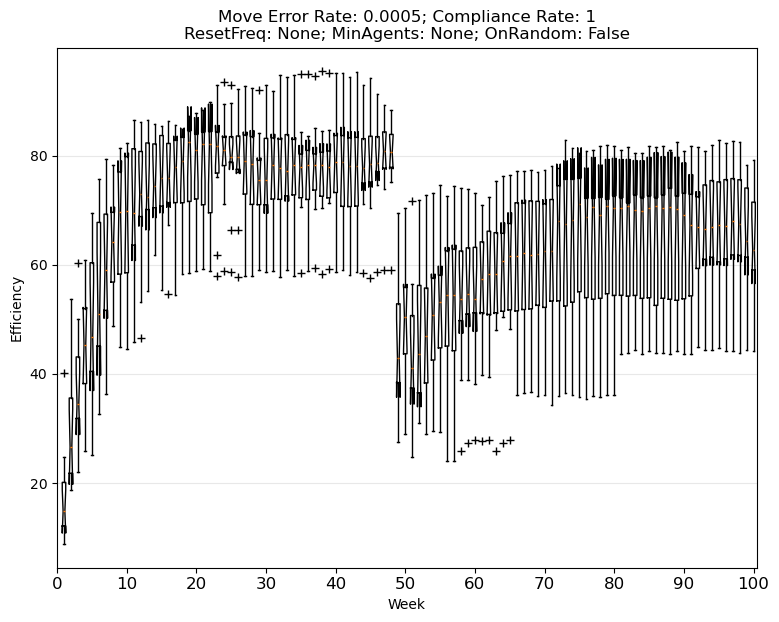

In [33]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.0005
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 10))

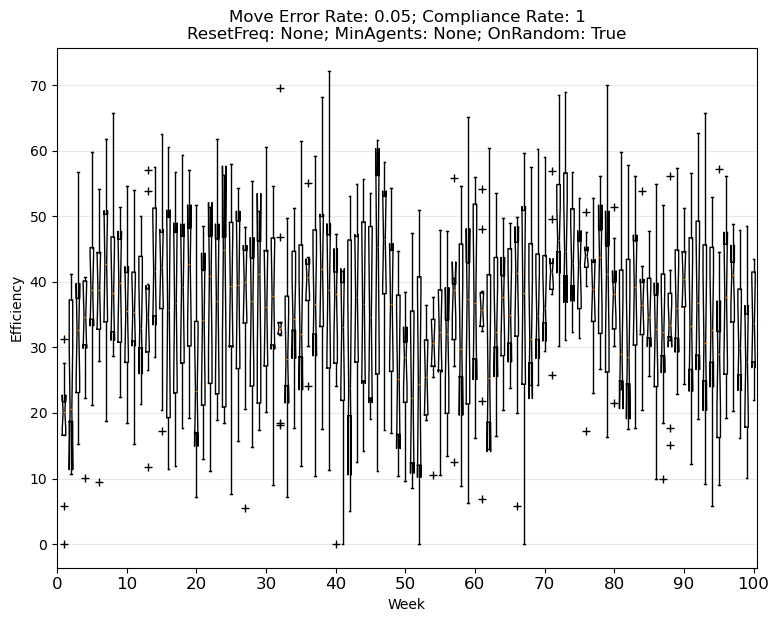

In [34]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.05
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=True

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 10))

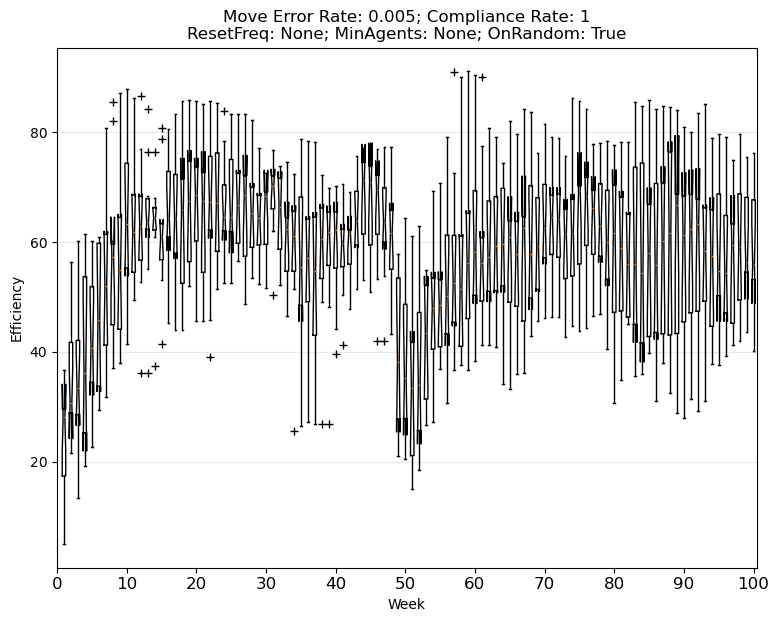

In [35]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.005
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=True

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 10))

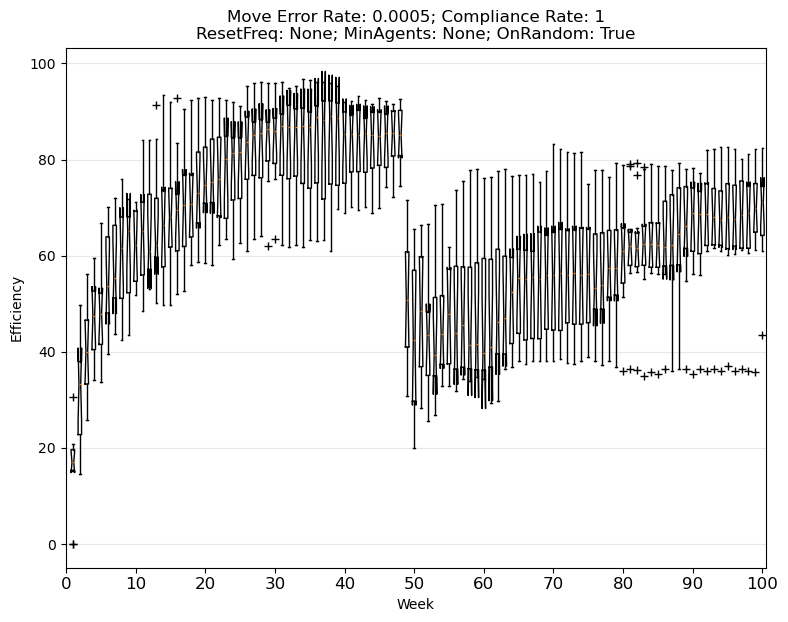

In [36]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0.0005
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=True

test1 = make_event_monte_carlo("test1", *common_controls, movement_error_rate, compliance_rate, return_df=True, reset_flag_frequency=reset_freq, reset_flag_min_agents=min_agents,
             reset_flag_on_random=on_random)

td_boxplot = format_df_for_boxplot(test1, 'week', 'eff')

#plt.axvspan(event_begin, event_end, color="grey", alpha=0.3)
tlt = f"Move Error Rate: {movement_error_rate}; Compliance Rate: {compliance_rate}\nResetFreq: {reset_freq}; MinAgents: {min_agents}; OnRandom: {on_random}"
plot_boxplot_data(td_boxplot, title=tlt, y_lab="Efficiency", x_lab="Week", x_ticks=np.arange(0, num_weeks+1, 10))

In [40]:
num_trials = 10; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0
compliance_rate = 1

reset_freq=None
min_agents=None
on_random=False



# Treatment names
movement_error_rate_s = [0, 0.05, 0.005, 0.0005]
compliance_rate_s = [1]

reset_freq_s = [None, "START", "PERIOD", "MIN_AGENTS", "WEEK", "WINDOW"]
min_agents=None

reset_freq=None
min_agents=None
on_random=True

<Figure size 640x480 with 0 Axes>

'/Users/alex/Repos/dm_markets/modules_vCOVID/notebooks'

In [37]:
raise ValueError("END")

ValueError: END

In [ ]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 10; grid_size = 15; num_traders = 20; num_units = 8; 
lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0; compliance_rate = 1
treatment_vars = [movement_error_rate, compliance_rate]

test_rd = make_event_monte_carlo("test1", *common_controls, *treatment_vars, return_df=True)

plt.plot(test_rd['eff'])

In [ ]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 20; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 10; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0; compliance_rate = 1
treatment_vars = [movement_error_rate, compliance_rate]

test_pd = make_event_monte_carlo("test_lg", *common_controls, *treatment_vars, return_df=True)

plt.plot(test_pd['eff'])

In [ ]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 20; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 10; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0; compliance_rate = 1
treatment_vars = [movement_error_rate, compliance_rate]

test_lg = make_event_monte_carlo("test_lg", *common_controls, *treatment_vars, return_df=True)

plt.plot(test_lg['eff'])

In [ ]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 20; num_weeks = 500; event_begin = 90000; event_end = 9000000; num_rounds = 20; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0; compliance_rate = 1
treatment_vars = [movement_error_rate, compliance_rate]

test_sp = make_event_monte_carlo("test_sp", *common_controls, *treatment_vars, return_df=True)

plt.plot(test_sp['eff'])

In [ ]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 20; num_weeks = 500; event_begin = 90000; event_end = 9000000; num_rounds = 20; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0; compliance_rate = 1
treatment_vars = [movement_error_rate, compliance_rate]

test_sp_rd = make_event_monte_carlo("test_sp_rd", *common_controls, *treatment_vars, return_df=True)

plt.plot(test_sp_rd['eff'])

In [ ]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 20; num_weeks = 500; event_begin = 48; event_end = 52; num_rounds = 10; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

movement_error_rate = 0; compliance_rate = 1
treatment_vars = [movement_error_rate, compliance_rate]

test_pd = make_event_monte_carlo("test_lg", *common_controls, *treatment_vars, return_df=True)

plt.plot(test_pd['eff'])

In [ ]:
test1, test1_p = make_event_monte_carlo("test1", *common_controls, movement_error_rate = 0.0, compliance_rate = 1, return_df=True, return_period_df=True)
plotted_t1 = collate_loc_plots(test1_p)

In [ ]:
mname = "Event_Sim_Test_1_E0_C1_v2_upd"
mname2 = mname+".mp4"
movie_plotted(plotted_t1, movie_name=mname2, graph_folder=mname, title_val="Event Simulation - Error Rate=0, Compliance Rate=1", hue_val="Agents", size_val="Agents", scale="relative", hue_max=None, 
                  size_max=None, week_max=None, period_max=None, include_init=True, fps=1, subtitle=True)

In [ ]:
ZIDPA = dm_agents.ZIDPA
ZID = dm_agents.ZIDPR
num_trials = 1; num_periods = 7; num_weeks = 100; event_begin = 48; event_end = 52; num_rounds = 5; grid_size = 15; num_traders = 20; num_units = 8; lower_bound = 200; upper_bound = 600
trader_objects =[(ZIDPA, 20),(ZID, 0)]
common_controls = [num_trials, num_periods, num_weeks,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]

test2, test2_p = make_event_monte_carlo("test2", *common_controls, movement_error_rate = 0.05, compliance_rate = 1, return_df=True, return_period_df=True)

In [ ]:
plt.plot(test2['eff'])

In [ ]:
plotted_t2 = collate_loc_plots(test2_p)
movie_plotted(plotted_t2, movie_name="Event_Sim_Test_1_E005_C1_upd.mp4", graph_folder="Event_Sim_E005_C1_upd", title_val="Event Simulation - Error Rate=0.05, Compliance Rate=1", hue_val="Agents", size_val="Agents", scale="relative", hue_max=None, 
                  size_max=None, week_max=None, period_max=None, include_init=True, fps=1, subtitle=True)

In [ ]:
test3, test3_p = make_event_monte_carlo("test3", *common_controls, movement_error_rate = 0.005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test3['eff'])

In [ ]:
plotted_t3 = collate_loc_plots(test3_p)
movie_plotted(plotted_t3, movie_name="Event_Sim_Test_1_E0005_C1_upd.mp4", graph_folder="Event_Sim_E0005_C1_upd", title_val="Event Simulation - Error Rate=0.005, Compliance Rate=1", hue_val="Agents", size_val="Agents", scale="relative", hue_max=None, 
                  size_max=None, week_max=None, period_max=None, include_init=True, fps=1, subtitle=True)

In [ ]:
test4, test4_p = make_event_monte_carlo("test4", *common_controls, movement_error_rate = 0.0005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test4['eff'])


In [ ]:
plotted_t4 = collate_loc_plots(test4_p)
movie_plotted(plotted_t4, movie_name="Event_Sim_Test_U_E00005_C1_upd.mp4", graph_folder="Event_Sim_E00005_C1_upd", title_val="Event Simulation - Error Rate=0.0005, Compliance Rate=1", hue_val="Agents", size_val="Agents", scale="relative", hue_max=None, 
                  size_max=None, week_max=None, period_max=None, include_init=True, fps=1, subtitle=True)

In [ ]:
test5, test5_p = make_event_monte_carlo("test5", *common_controls, movement_error_rate = 0.00005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test5['eff'])

In [ ]:
plotted_t5 = collate_loc_plots(test5_p)
movie_plotted(plotted_t5, movie_name="Event_Sim_Test_U_E000005_C1_r_upd.mp4", graph_folder="Event_Sim_E000005_C1_r_upd", title_val="Event Simulation - Error Rate=0.0005, Compliance Rate=1", hue_val="Agents", size_val="Agents", scale="relative", hue_max=None, 
                  size_max=None, week_max=None, period_max=None, include_init=True, fps=1, subtitle=True)

In [ ]:
common_controls = [num_trials, num_periods, 500,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    20, num_units,
                    lower_bound, upper_bound,
                    [(ZIDPA, 20),(ZID, 0)]]
test7, test7_p = make_event_monte_carlo("test5", *common_controls, movement_error_rate = 0.000005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test7['eff'])

In [ ]:
test6, test6_p = make_event_monte_carlo("test5", *common_controls, movement_error_rate = 0.000005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test6['eff'])

In [ ]:
common_controls = [num_trials, num_periods, 500,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    6, num_units,
                    lower_bound, upper_bound,
                    [(ZIDPA, 6),(ZID, 0)]]
test7, test7_p = make_event_monte_carlo("test5", *common_controls, movement_error_rate = 0.000005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test7['eff'])

In [ ]:
common_controls = [num_trials, num_periods, 500,
                    event_begin, event_end,
                    num_rounds, grid_size,
                    num_traders, num_units,
                    lower_bound, upper_bound,
                    trader_objects]
test8, test8_p = make_event_monte_carlo("test5", *common_controls, movement_error_rate = 0.0005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test8['eff'])

In [ ]:
common_controls = [num_trials, num_periods, 100, # num_weeks
                    event_begin, event_end, 
                    num_rounds, grid_size,
                    6, num_units,
                    lower_bound, upper_bound,
                    [(ZIDPA, 6)]]
test9, test9_p = make_event_monte_carlo("test5", *common_controls, movement_error_rate = 0.0005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test9['eff'])

In [ ]:
common_controls = [num_trials, num_periods, 100, # num_weeks
                    event_begin, event_end, 
                    num_rounds, grid_size,
                    20, num_units,
                    lower_bound, upper_bound,
                    [(ZIDPA, 20)]]
test9, test9_p = make_event_monte_carlo("test5", *common_controls, movement_error_rate = 0.0005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test9['eff'])

In [ ]:
common_controls = [num_trials, num_periods, 100, # num_weeks
                    event_begin, event_end, 
                    num_rounds, grid_size,
                    50, num_units,
                    lower_bound, upper_bound,
                    [(ZIDPA, 50)]]
test9, test9_p = make_event_monte_carlo("test5", *common_controls, movement_error_rate = 0.0005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test9['eff'])

In [ ]:
common_controls = [num_trials, num_periods, 500, # num_weeks
                    event_begin, event_end, 
                    num_rounds, grid_size,
                    50, num_units,
                    lower_bound, upper_bound,
                    [(ZIDPA, 50)]]
test9, test9_p = make_event_monte_carlo("test5", *common_controls, movement_error_rate = 0.0005, compliance_rate = 1, return_df=True, return_period_df=True)
plt.plot(test9['eff'])

In [ ]:
def make_make_event_monte_carlo(dict_inputs, return_df=False, return_period_df=False, graph_eff=False):
    """Maker for maker of monte carlo. Returns outputs as df, but can specify detail level (1, 2, 3). Can graph efficiencies in a 2D grid - only available for two-at-a-time or 1-at-a-time treatments."""

    # System vars
    n_trials = dict_inputs['num_trials'] # Cannot be a treatment var

    # Control vars
    n_periods = dict_inputs['num_periods']
    n_weeks = dict_inputs['num_weeks']
    e_beg = dict_inputs['event_begin']
    e_end = dict_inputs['event_end']
    n_rnds = dict_inputs['num_rounds']
    g_sz = dict_inputs['grid_size']
    n_trdrs = dict_inputs['num_traders']
    n_units = dict_inputs['num_units']
    l_bd = dict_inputs['lower_bound']
    u_bd = dict_inputs['upper_bound']
    trd_types = [(ZIDPA, n_trdrs)] # Hardcoded yes

    # Main tratment vars
    move_err = dict_inputs['movement_error_rate']
    comp_rt = dict_inputs['compliance_rate']    
    